In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import numpy as np
import random as ra
import operator

from whoosh.index import create_in
from whoosh.fields import *
import os.path, shutil
from whoosh.index import create_in
from whoosh.fields import Schema, STORED, ID, KEYWORD, TEXT
from whoosh.qparser import QueryParser

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
%matplotlib inline
#%matplotlib


In [3]:
# Using whoosh package to find all the documents that have the quey term

def search(q, print_search=False):
    #q: the qury the term
    
    with ix.searcher() as searcher:
        query = QueryParser("content", ix.schema).parse(q)
        results = searcher.search(query,limit=None)
        
        # generating the list of documents that have the query q
        r=len(results)
        output=[]
        for i in range(r):
            title=results[i]['title']
            
            output.append(title)
            

    found = results.scored_length()
    if (print_search):
        if results.has_exact_length():
            print("Scored", found, "of exactly", len(results), "documents")
        else:
            low = results.estimated_min_length()
            high = results.estimated_length()

            print("Scored", found, "of between", low, "and", high, "documents")
    
    return output

In [4]:
#updating the score of each document based on the list of results (TF-IDF)

def score_update(scores,results,ls, itr):
    #scores: the score dictaionary from previous searches
    #results: the list of returned document from search
    # ls is number of sentences in the observation
    # itr number of searches for each sentence
    
    N=len(results)
    
    for result in results:
        if scores.has_key(result):
            scores[result]+=1.0/N/ls/itr
        else:
            scores[result]=1.0/N/ls/itr
    return scores

In [5]:
# Implementation of rough search based on chunking and boosting

def rough_search(observation, N=10, Nword=3, print_query=False):
    # Observation: The observation text
    # N : the number of search iteration per sentence
    # Nword: number of words in a sentence in each search
    
    sentences=observation.replace('\n', ' ').split('.')

    scores={}
    
    ls=len(sentences)
    for sentence in sentences:
        words= sentence.split(' ')
        for i in range(N):
            q=""
            if (len(words)>Nword):
                for _ in range(Nword):
                    q+=words[int(ra.uniform(0,len(words)))]+' '

                if(print_query): print q
                scores=score_update(scores,search(q), ls, N)
            
    return scores
    

In [6]:
# Implementation of fine search based on chunking and TFIDF feature vector and inner product similarity score

def fine_search(observation, scores, N_refine=10, Ngram_min=2, Ngram_max=3):
    
    
    rank=pd.DataFrame(columns=('documen','similarity', 'most_similar' ))
    N_refine=min(N_refine, len(scores))
    
    sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
    j=0
    for i in range(min(N_refine, len(scores))):
        
        pages=books['content'][book_map[sorted_scores[i][0]]].split('\n\n')
        
        
        max_similarity=0
        max_similar_page=""
        
        for page in pages:
            text=[page]
            text.append(observation)
        

            count_vect = CountVectorizer(ngram_range =(Ngram_min,Ngram_max))
            X_counts = count_vect.fit_transform(text)
            
            tfidf_transformer = TfidfTransformer()
            X_tfidf = tfidf_transformer.fit_transform(X_counts)
            

            a=X_tfidf[0].dot(X_tfidf[1].transpose()).todense();
            if(a.item(0)>max_similarity):
                max_similarity=a.item(0)
                max_similar_page=page
                
        
        rank.loc[j]=[sorted_scores[i][0], max_similarity, max_similar_page]
        j+=1
        
            
            
    
    
    return rank

In [7]:
def score_plot(score, N_max, search):
    N_max=min(N_max, len(scores))
    sorted_ranks = sorted(score.items(), key=operator.itemgetter(1), reverse=True)

    index=np.arange(N_max)
    a=[sorted_ranks[i][1] for i in range(N_max) ]
    label=[sorted_ranks[i][0] for i in range(N_max) ]

    
    if (search=="fine"):
        plt.barh(index,a,color='r')
        plt.yticks(index+0.5, label, rotation='horizontal')
        plt.title("Fine Search: Top %d documents"%N_max)
    elif(search=="rough"):
        plt.barh(index,a,color='g')
        plt.yticks(index+0.5, label, rotation='horizontal')
        plt.title("rough Search: Top %d documents"%N_max)
    else:
        plt.barh(index,a,color='b')
        plt.yticks(index+0.5, label, rotation='horizontal')
        plt.title("Top %d documents"%N_max)
        
    plt.xlabel('Similarity score')
    plt.grid()
    plt.show()

In [8]:
def score_plot2(rank, N_max, search):
    N_max=min(N_max, len(scores))
    
    index=np.arange(N_max)
    a=rank['similarity']
    label=rank['documen']

    
    if (search=="fine"):
        plt.barh(index,a,color='r')
        plt.yticks(index+0.5, label, rotation='horizontal')
        plt.title("Fine Search: Top %d documents"%N_max)
    elif(search=="rough"):
        plt.barh(index,a,color='g')
        plt.yticks(index+0.5, label, rotation='horizontal')
        plt.title("rough Search: Top %d documents"%N_max)
    else:
        plt.barh(index,a,color='b')
        plt.yticks(index+0.5, label, rotation='horizontal')
        plt.title("Top %d documents"%N_max)
        
    plt.xlabel('Similarity score')
    plt.grid()
    plt.show()

In [9]:
# Training Data

books = pd.DataFrame(columns=('title', 'author', 'content'))

i=0

title="The Mercer Boys on a Treasure Hunt".decode('utf-8','replace')
content=open('sample.txt', 'r').read().decode('utf-8','replace')
author="Capwell Wyckoff".decode('utf-8','replace')
books.loc[i]=[title, author, content]
i+=1


title="Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe".\
decode('utf-8','replace')
content=open('sample0.txt', 'r').read().decode('utf-8','replace')
author="John J. McLaurin".decode('utf-8','replace')
books.loc[i]=[title, author, content]
i+=1


title="Modern Poets and Poetry of Spain".decode('utf-8','replace')
content=open('sample1.txt', 'r').read().decode('utf-8','replace')
author="James Kennedy".decode('utf-8','replace')
books.loc[i]=[title, author, content]
i+=1


title="Kate Vernon, Vol. 3 (of 3) A tale. In three volumes".decode('utf-8','replace')
content=open('sample2.txt', 'r').read().decode('utf-8','replace')
author="Mrs. Alexander".decode('utf-8','replace')
books.loc[i]=[title, author, content]
i+=1


title="War Department Technical Manual TM 3-376 A, Portable Flame Thrower M2-2".decode('utf-8','replace')
content=open('sample3.txt', 'r').read().decode('utf-8','replace')
author="War Department".decode('utf-8','replace')
books.loc[i]=[title, author, content]
i+=1

book_map=dict(zip(books['title'],range(len(books['title']))))

books

,title,author,content
0,The Mercer Boys on a Treasure Hunt,Capwell Wyckoff,Project Gutenberg's The Mercer Boys on a Treas...
1,Sketches in Crude-oil Some accidents and incid...,John J. McLaurin,﻿The Project Gutenberg EBook of Sketches in Cr...
2,Modern Poets and Poetry of Spain,James Kennedy,﻿Project Gutenberg's Modern Poets and Poetry o...
3,"Kate Vernon, Vol. 3 (of 3) A tale. In three vo...",Mrs. Alexander,"﻿The Project Gutenberg EBook of Kate Vernon, V..."
4,"War Department Technical Manual TM 3-376 A, Po...",War Department,﻿The Project Gutenberg EBook of War Department...


In [10]:
# Test Data

observations=pd.DataFrame(columns=('source', 'author', 'content'))
i=0

source="The Mercer Boys on a Treasure Hunt".decode('utf-8','replace')
author="Capwell Wyckoff".decode('utf-8','replace')

content=content=open('observation0.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observation0.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observation1.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observation2.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1


source="Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe"\
.decode('utf-8','replace')
author="John J. McLaurin".decode('utf-8','replace')

content=content=open('observation00.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observation01.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observation02.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1


source="Modern Poets and Poetry of Spain".decode('utf-8','replace')
author="James Kennedy".decode('utf-8','replace')

content=content=open('observation10.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observation11.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

source="Not in Database".decode('utf-8','replace')
author="Capwell Wyckoff".decode('utf-8','replace')

content=content=open('observationx0.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

source="Not in Database".decode('utf-8','replace')
author="Capwell Wyckoff".decode('utf-8','replace')

content=content=open('observationx1.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

source="Not in Database".decode('utf-8','replace')
author="Unknown".decode('utf-8','replace')

content=content=open('observationy0.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observationy1.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observationy2.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1

content=content=open('observationy2.txt', 'r').read().decode('utf-8','replace')
observations.loc[i]=[source, author, content]
i+=1



observations


,source,author,content
0,The Mercer Boys on a Treasure Hunt,Capwell Wyckoff,\nJim took the first watch and Terry the secon...
1,The Mercer Boys on a Treasure Hunt,Capwell Wyckoff,\nJim took the first watch and Terry the secon...
2,The Mercer Boys on a Treasure Hunt,Capwell Wyckoff,\nWhile the relief party was taking this in th...
3,The Mercer Boys on a Treasure Hunt,Capwell Wyckoff,"\n“As I told you, that had happened in the eve..."
4,Sketches in Crude-oil Some accidents and incid...,John J. McLaurin,"\nLeaving the realm of conjecture, it is quite..."
5,Sketches in Crude-oil Some accidents and incid...,John J. McLaurin,Gunda a well yielded eleven gallons a day for ...
6,Sketches in Crude-oil Some accidents and incid...,John J. McLaurin,"\nArriving late one Saturday at Mt. Vernon, th..."
7,Modern Poets and Poetry of Spain,James Kennedy,There is another mistake into which some write...
8,Modern Poets and Poetry of Spain,James Kennedy,Heroic worth and honour to descry;\n ...
9,Not in Database,Capwell Wyckoff,“It’s a dandy day for a snow fight like we had...


In [11]:
# Indexing the books using Whoosh package

indexdir = 'indexdir'
if not os.path.exists(indexdir):
    os.mkdir(indexdir)


schema = Schema(title=TEXT(stored=True), path=ID(stored=True), tags=KEYWORD, content=TEXT)

ix = create_in(indexdir, schema)

writer = ix.writer()

(a,_)=books.shape
for i in range(a):
    
    title=books.loc[i]['title']
    content=books.loc[i]['content']
    writer.add_document(title=title, content=content)
    print "indexd: ", title

writer.commit()

indexd:  The Mercer Boys on a Treasure Hunt
indexd:  Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe
indexd:  Modern Poets and Poetry of Spain
indexd:  Kate Vernon, Vol. 3 (of 3) A tale. In three volumes
indexd:  War Department Technical Manual TM 3-376 A, Portable Flame Thrower M2-2


Observed from:  The Mercer Boys on a Treasure Hunt


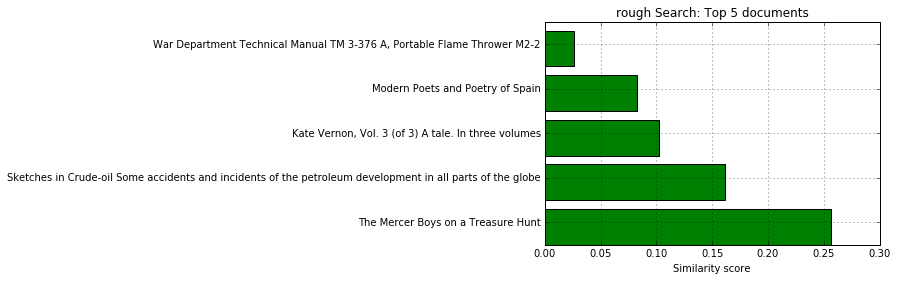

In [31]:
observation=observations.loc[0]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  The Mercer Boys on a Treasure Hunt


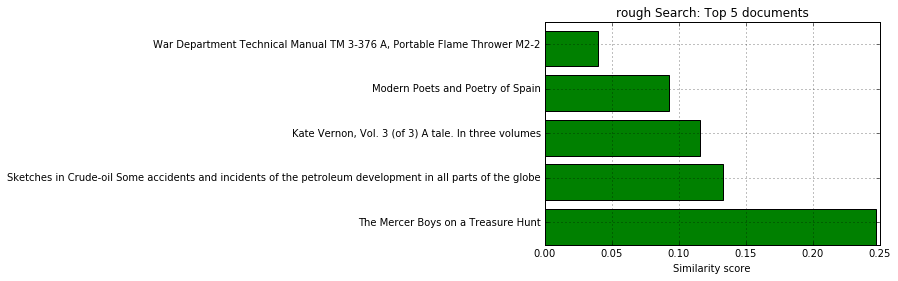

In [32]:
observation=observations.loc[1]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  The Mercer Boys on a Treasure Hunt


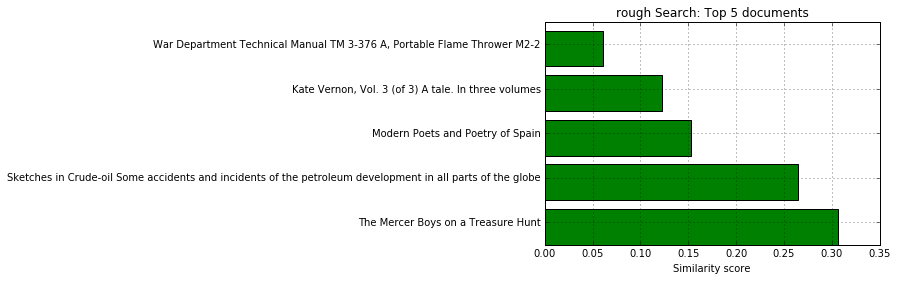

In [12]:
observation=observations.loc[2]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  The Mercer Boys on a Treasure Hunt


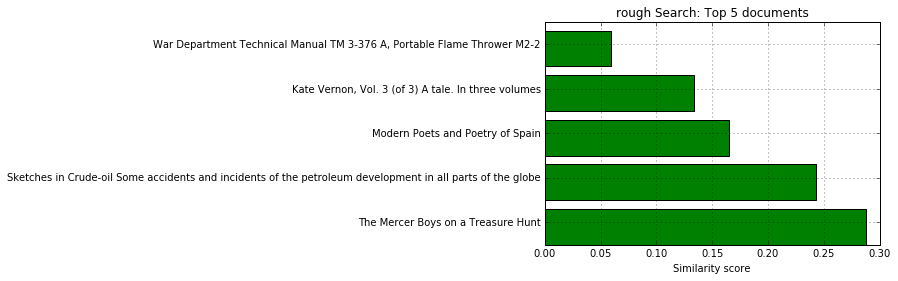

In [33]:
observation=observations.loc[3]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe


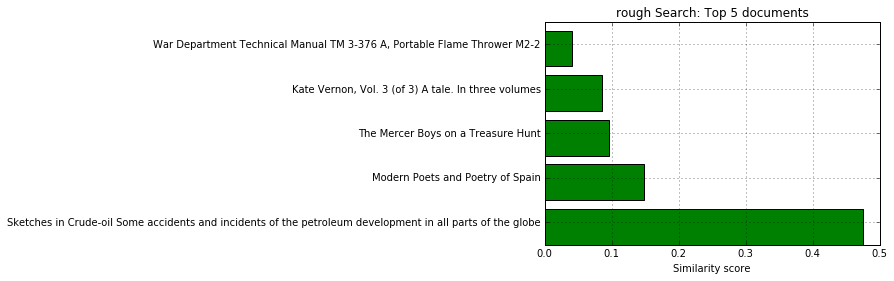

In [34]:
observation=observations.loc[4]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe


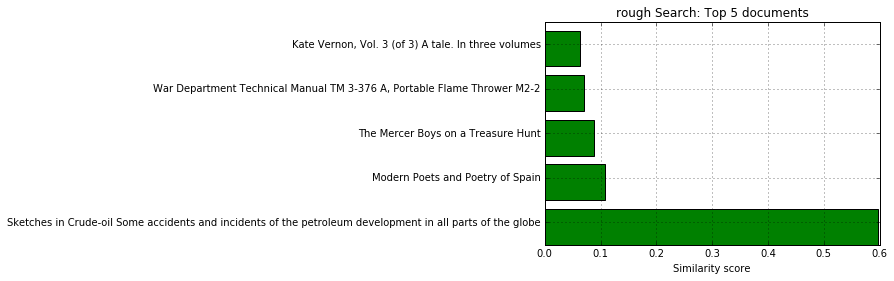

In [35]:
observation=observations.loc[5]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe


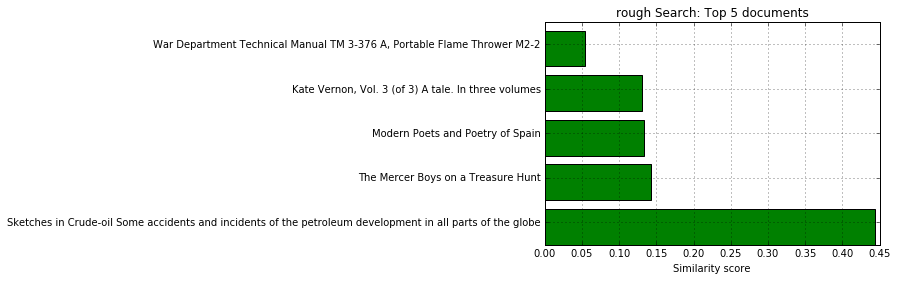

In [36]:
observation=observations.loc[6]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Modern Poets and Poetry of Spain


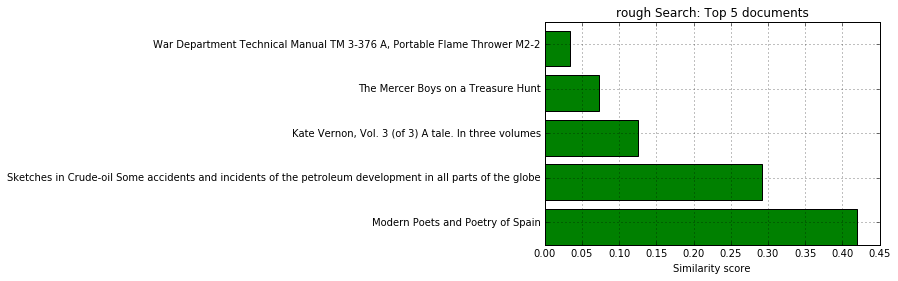

In [37]:
observation=observations.loc[7]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Modern Poets and Poetry of Spain


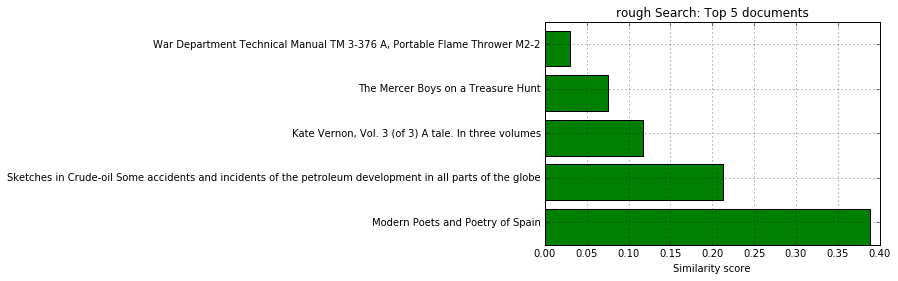

In [38]:
observation=observations.loc[8]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Not in Database


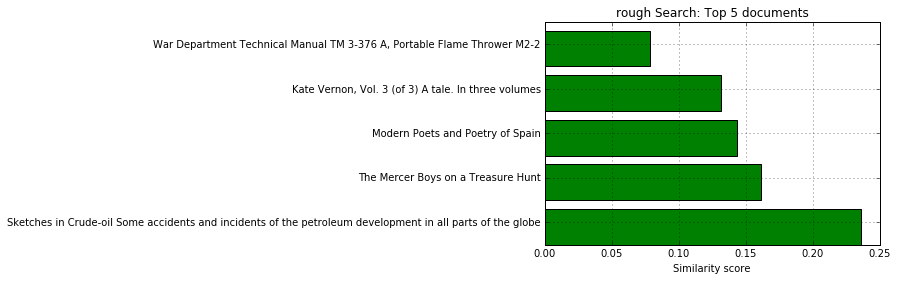

In [39]:
observation=observations.loc[9]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Not in Database


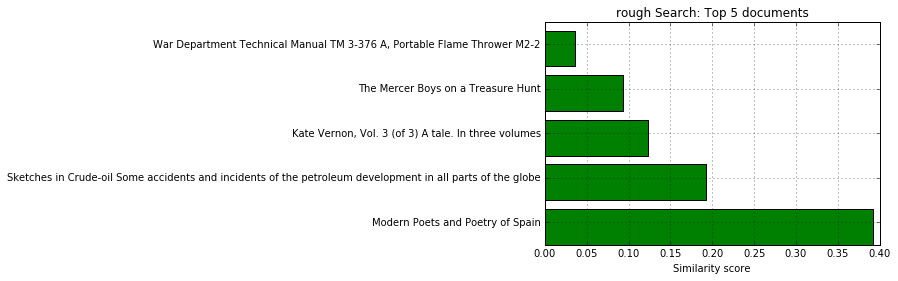

In [40]:
observation=observations.loc[10]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Not in Database


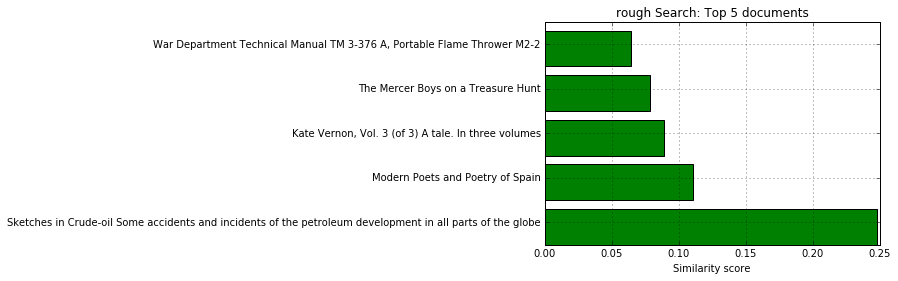

In [41]:
observation=observations.loc[11]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Not in Database


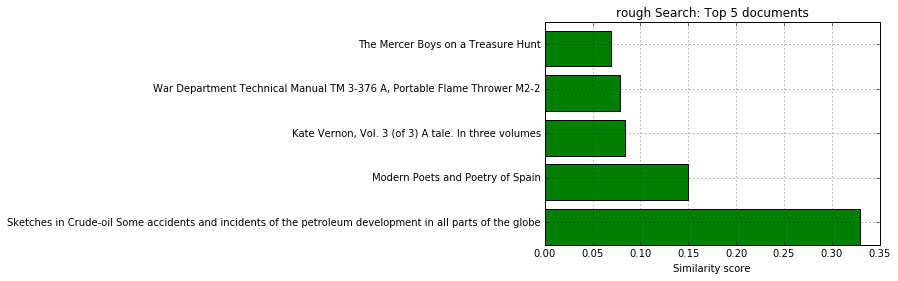

In [42]:
observation=observations.loc[12]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  Not in Database


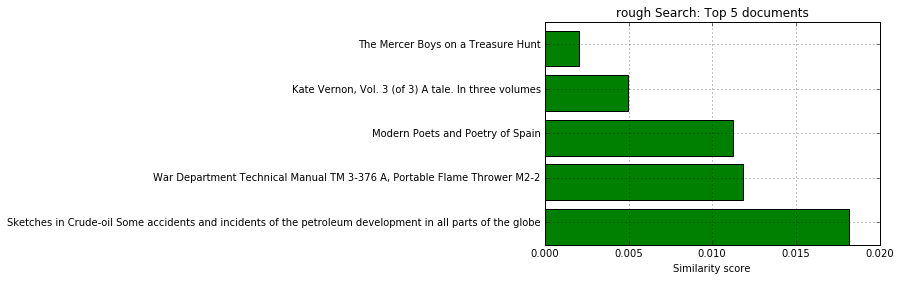

In [43]:
observation=observations.loc[13]


scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)

N_max=5

print "Observed from: ", observation['source']
score_plot(scores, N_max, 'rough')

Observed from:  The Mercer Boys on a Treasure Hunt


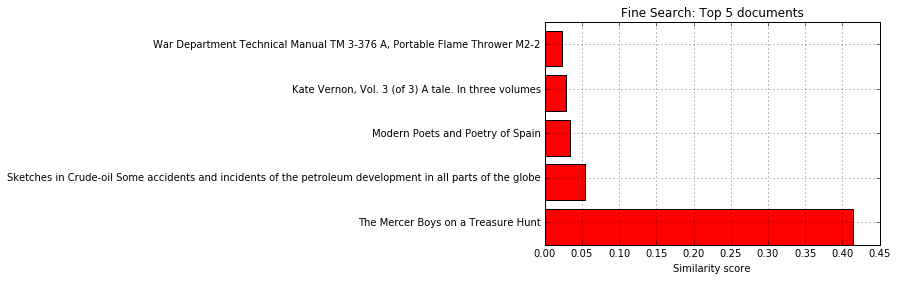

In [13]:
rank=fine_search(observations['content'][0], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][0]
score_plot2(rank, N_refine, 'fine')

Observed from:  The Mercer Boys on a Treasure Hunt


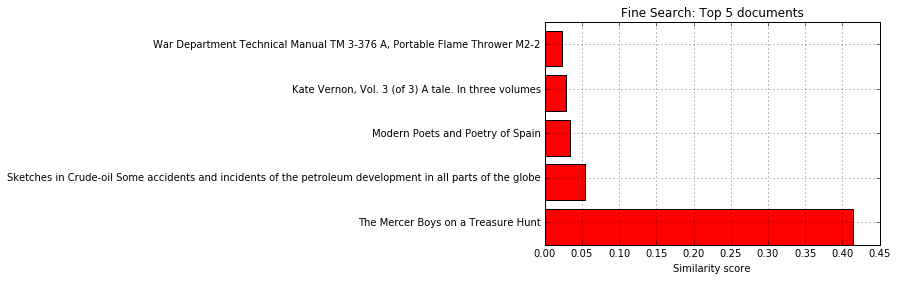

In [14]:
i=1
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  The Mercer Boys on a Treasure Hunt


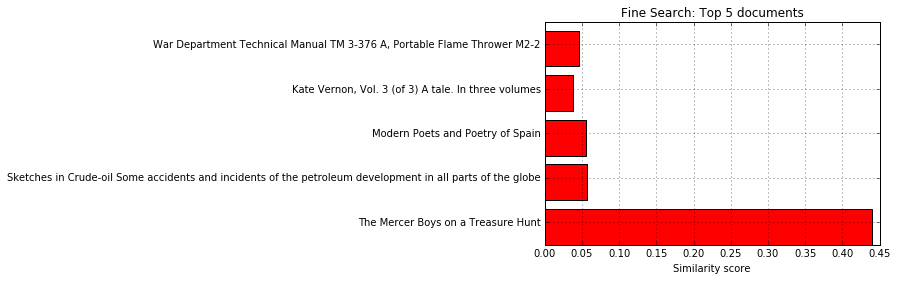

In [15]:
i=2

rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  The Mercer Boys on a Treasure Hunt


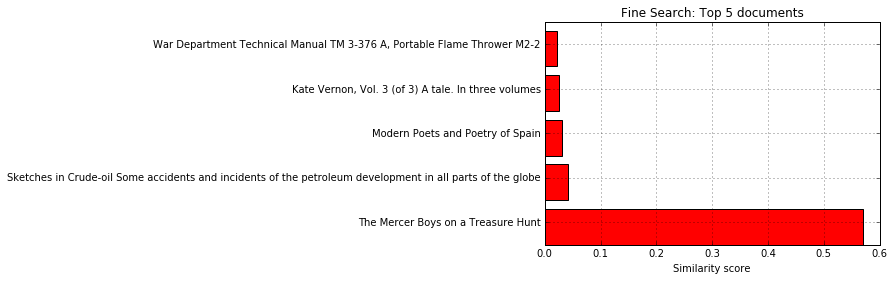

In [16]:
i=3
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe


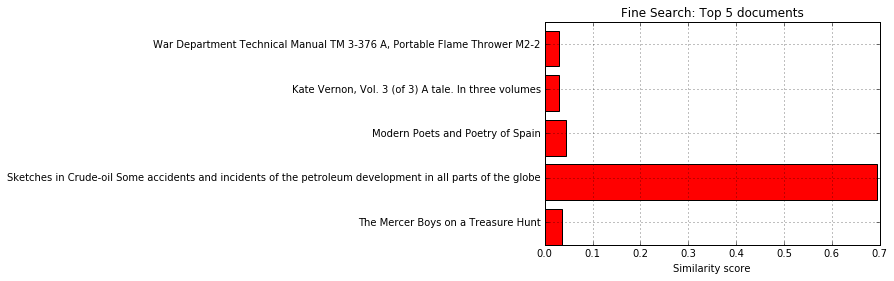

In [17]:
i=4
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe


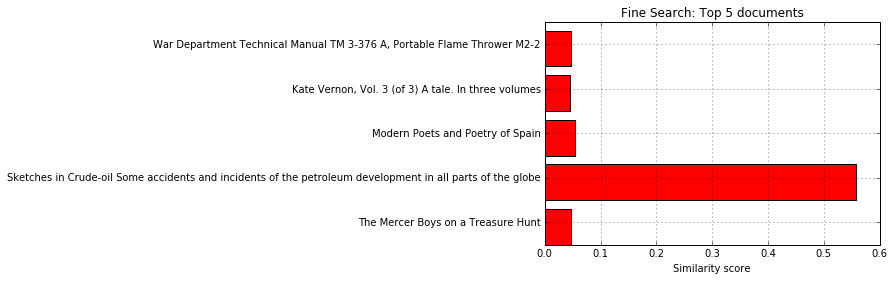

In [18]:
i=5
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Sketches in Crude-oil Some accidents and incidents of the petroleum development in all parts of the globe


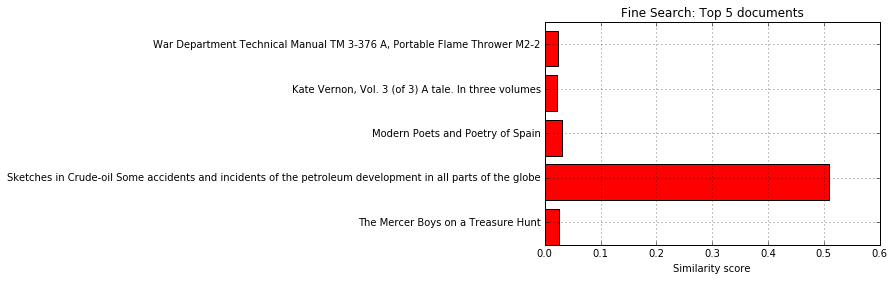

In [19]:
i=6
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Modern Poets and Poetry of Spain


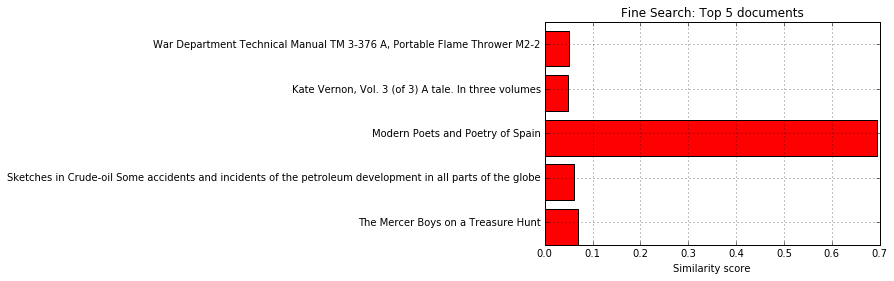

In [20]:
i=7
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Modern Poets and Poetry of Spain


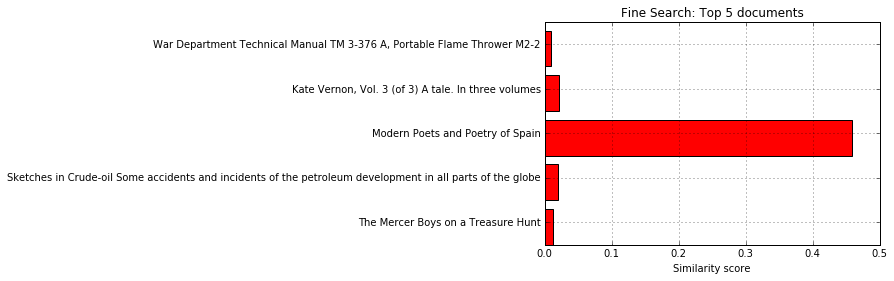

In [21]:
i=8
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Not in Database


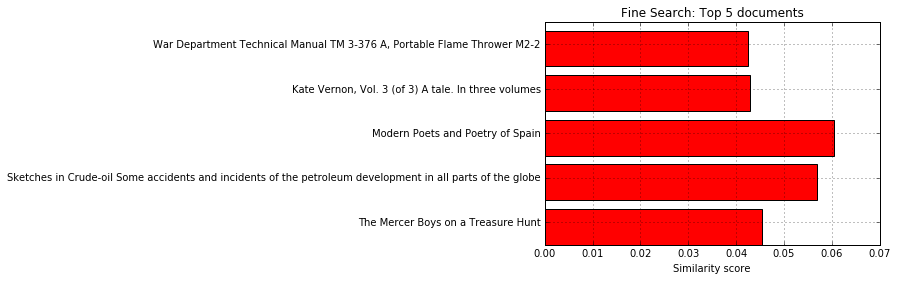

In [22]:
i=9
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Not in Database


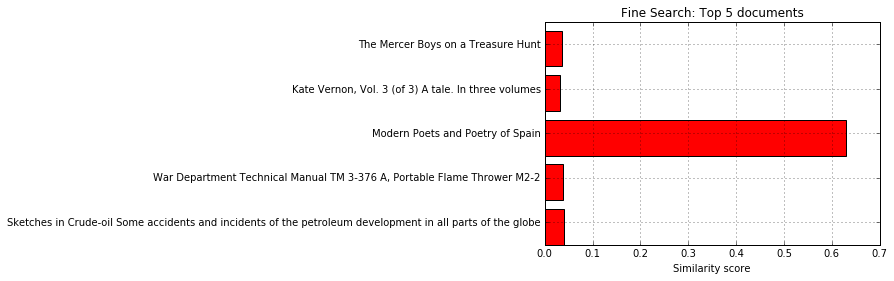

In [52]:
i=10
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

In [53]:
print rank['most_similar'][2]

This ill-success gave occasion to several detractors of Melendez to
pour forth the effusions of envy or disappointment against him, to
which he gave no other answer than by the publication of his poems
in a collected form. This was in 1785; and the manner in which they
were received, it could be said, had had no parallel in Spain. Four
editions, of which three were furtive, were at once taken up, and all
classes of persons seemed to have the book in hand, commenting on its
excellences. The lovers of ancient poetry, who saw so happily renewed
the graces of Garcilasso, of Leon and Herrera, and “even improved
in taste and perfection,” saluted Melendez as the restorer of the
Castillian Muses, and hailed the banishment of the prosaic style which
had previously prevailed. The applauses extended beyond the kingdom,
and found especially in Italy the admiration repeated, as well as in
France and England, where several of the poems are said to have been
imitated.


In [51]:
print observations["content"][10]

In 1784, on the occasion of peace being made with England, and the
birth of twin Infantes, to give hopes of secure succession to the
throne, the city of Madrid prepared magnificent celebrations of
rejoicings, and among the rest, a prize was proposed for the two best
dramatic pieces that might be offered within sixty days, under the
condition that they should be original, appropriate, and capable of
theatrical pomp and ornament. Out of fifty-seven dramas that were
offered, the prize was awarded to the one sent in by Melendez, ‘The
Bridals of Comacho the Rich,’ a pastoral comedy, which, however, though
abounding in poetical passages, was found on representation wanting
in effect, so as to be coldly received on the stage, where it has not
since been attempted.

This ill-success gave occasion to several detractors of Melendez to
pour forth the effusions of envy or disappointment against him, to
which he gave no other answer than by the publication of his poems
in a collected form. This was

Observed from:  Not in Database


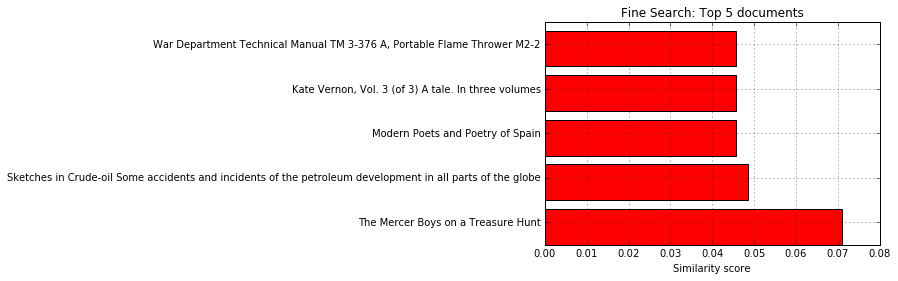

In [24]:
i=11
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Not in Database


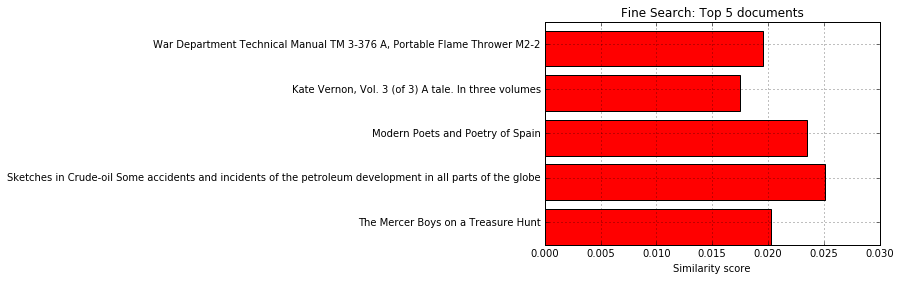

In [25]:
i=12
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

Observed from:  Not in Database


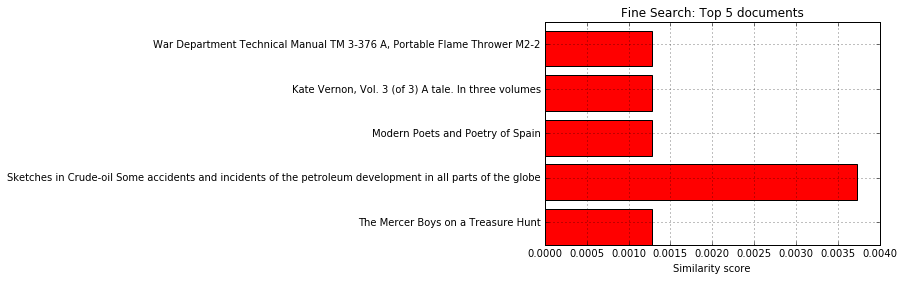

In [26]:
i=13
rank=fine_search(observations['content'][i], scores, N_refine=10, Ngram_min=2, Ngram_max=3)

N_refine=10

print "Observed from: ", observations['source'][i]
score_plot2(rank, N_refine, 'fine')

In [27]:
score_max=[]
rank_max=[]
for i in range(len(observations)):
    print "Observation %d"% i
    observation=observations.loc[i]

    print " - Rough Search"
    scores=rough_search(observation['content'], N=10, Nword=3, print_query=False)
    
    print " - Fine Search"
    rank=fine_search(observation['content'], scores, N_refine=10, Ngram_min=2, Ngram_max=3)
    
    score_max.append(max(scores.values()))
    rank_max.append(max(rank['similarity']))

Observation 0
 - Rough Search
 - Fine Search
Observation 1
 - Rough Search
 - Fine Search
Observation 2
 - Rough Search
 - Fine Search
Observation 3
 - Rough Search
 - Fine Search
Observation 4
 - Rough Search
 - Fine Search
Observation 5
 - Rough Search
 - Fine Search
Observation 6
 - Rough Search
 - Fine Search
Observation 7
 - Rough Search
 - Fine Search
Observation 8
 - Rough Search
 - Fine Search
Observation 9
 - Rough Search
 - Fine Search
Observation 10
 - Rough Search
 - Fine Search
Observation 11
 - Rough Search
 - Fine Search
Observation 12
 - Rough Search
 - Fine Search
Observation 13
 - Rough Search
 - Fine Search
Observation 14
 - Rough Search
 - Fine Search


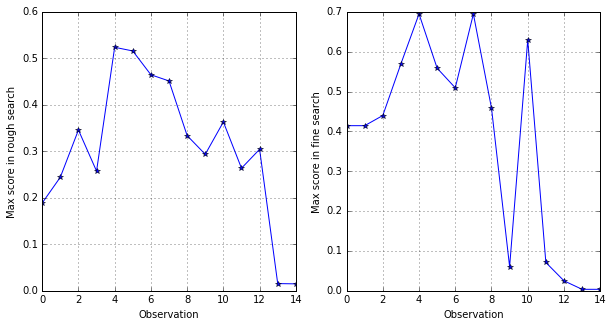

In [28]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(score_max,'-*')
plt.xlabel("Observation")
plt.ylabel("Max score in rough search")
plt.grid()

plt.subplot(122)
plt.plot(rank_max,'-*')
plt.xlabel("Observation")
plt.ylabel("Max score in fine search")
plt.grid()

plt.show()

In [48]:
# Author recognition
Ngram_min=1
Ngram_max=3

author_clf = Pipeline([('vect', CountVectorizer(ngram_range =(Ngram_min,Ngram_max))),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),])

author_clf = author_clf.fit(books['content'],books['author'])


author_predicted = author_clf.predict(observations['content'])

print(metrics.classification_report(observations['author'][0:10], author_predicted[0:10]))


                  precision    recall  f1-score   support

 Capwell Wyckoff       1.00      1.00      1.00         5
   James Kennedy       1.00      1.00      1.00         2
John J. McLaurin       1.00      1.00      1.00         3

     avg / total       1.00      1.00      1.00        10



In [49]:
author_clf.predict(observations['content'][0:10])

array([u'Capwell Wyckoff', u'Capwell Wyckoff', u'Capwell Wyckoff',
       u'Capwell Wyckoff', u'John J. McLaurin', u'John J. McLaurin',
       u'John J. McLaurin', u'James Kennedy', u'James Kennedy',
       u'Capwell Wyckoff'], 
      dtype='<U16')